In [90]:
import math, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Global utilities
ureg    = pint_pandas.PintType.ureg
dtime_t = pd.to_timedelta(1, unit='s')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_csv_mec(path, pint=True):
    '''Import Mecmesin data'''
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

def read_csv_dmm(path, pint=True, first_error=False):
    '''Import DMM data'''
    df = pd.read_csv(path, header=[0,1], index_col=[0])
    if pint:
        df = df.pint.quantify(-1)
    if first_error:
        df = df.iloc[1:]
    return df

def pint2dtime(times):
    '''Converts Pint time values to Pandas deltatime.'''
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        # Strip "pint[...]" text wrapping the unit string.
        unit = str(times.dtype)[5:-1]
    )

def event_times(event_coding):
    '''Extracts event start times from Mecmesin event coding.'''
    return event_coding[event_coding.diff() == -1].index

def time2state(times, events):
    '''
    Labels each time with an associated state based on Mecmesin event start times.
    I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
    '''
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

# User inputs
pressure_area = math.pi * (6.2 * ureg.mm / 2)**2
inf_threshold = 1e30 * ureg.ohm
data = [
    dotdict(
        mec_csv = 'testing/fsr 1s 1s 2mms 2n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/fsr.dmm.csv',
        label   = 'COTS FSR',
    ),
    dotdict(
        mec_csv = 'testing/sensor1 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor1.dmm.csv',
        label   = 'Sample 1',
    ),
    dotdict(
        mec_csv = 'testing/sensor2 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor2.dmm.csv',
        label   = 'Sample 2',
    ),
    dotdict(
        mec_csv = 'testing/sensor3 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor3.dmm.csv',
        label   = 'Sample 3',
    ),
    # dotdict(
    #     mec_csv = 'testing/sensor4 1s 1s 2mms 9n 0 9 50hz.mec.csv',
    #     dmm_csv = 'testing/sensor4.dmm.csv',
    #     label   = 'sensor4 1s 1s 2mms 9n 0 9 50hz',
    # ),
    # dotdict(
    #     mec_csv = 'testing/sensor4 1s 1s 2mms 9n 0 9 50hz test2.mec.csv',
    #     dmm_csv = 'testing/sensor4_test2.dmm.csv',
    #     label   = 'sensor4 1s 1s 2mms 9n 0 9 50hz test2',
    # ),
]

for dat in data:
    dat.mec_df = read_csv_mec(dat.mec_csv)
    dat.dmm_df = read_csv_dmm(dat.dmm_csv)

    dat.mec_df.index = pint2dtime(dat.mec_df.Time)
    dat.events = event_times(dat.mec_df.Event)
    dat.dmm_df.index = pint2dtime(dat.dmm_df.Time - dat.dmm_df.Time.iloc[0]) + dat.events[0]

max_sample_time = max([
    df.index.to_series().diff().max()
    for df in [dat.mec_df for dat in data] + [dat.dmm_df for dat in data]
])

for dat in data:
    dat.df = pd.concat(
        [
            dat.mec_df.resample(max_sample_time).mean()[['Force', 'Distance']],
            dat.dmm_df.resample(max_sample_time, offset=-dat.events[0]).mean()[['Resistance']]
        ],
        axis=1
    )

    # Strip data outside range of interest
    # dat.df = dat.df[(dat.df.Force >= 1*ureg.N) & (dat.df.Force <= 6*ureg.N)]

    # Condition data
    dat.df.loc[dat.df.Resistance >= inf_threshold, 'Resistance'] = pd.NA
    dat.df['ResNorm'] = dat.df.Resistance / dat.df.Resistance.max()
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)

    # Create Pint-unitless data copy to suppress Pyplot errors
    dat.dq = dat.df.pint.dequantify()
    # Remove unit headers from dequantify(). These cause problems with column access.
    dat.dq.columns = dat.dq.columns.droplevel(-1)

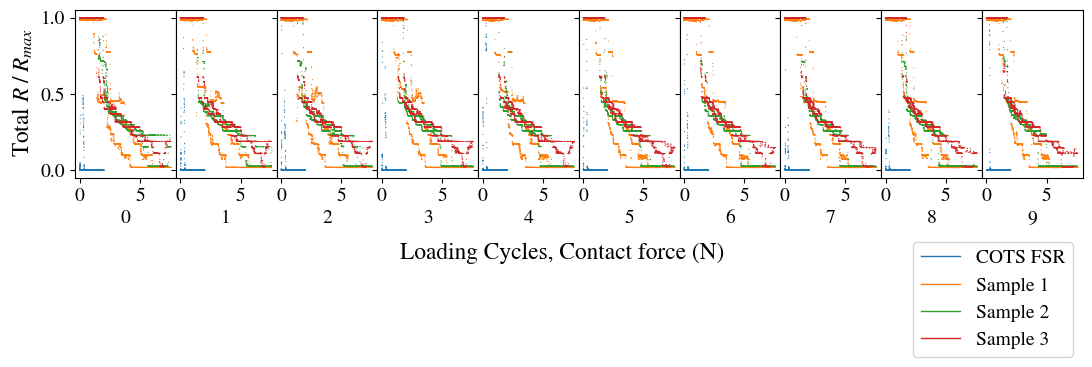

In [103]:
mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'

# Style figure, axes
fig, axes = plt.subplots(ncols=1+max([dat.dq.Cycle.max() for dat in data]), sharey=True, squeeze=False)
fig.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(13, 3.5)
# Style axes labels
for ax, i in zip(axes[0,:], itertools.count()):
    ax.set_box_aspect(5/3)
    ax.set_xlabel(i)
fig.supxlabel('Loading Cycles, Contact force (N)')
fig.supylabel('Total $R\\;/\\;R_{max}$', x=0.075)
# Style legend
fig.legend(
    [axes[0, 0].plot(np.NaN, np.NaN, lw=1, color=palette[i])[0] for i in range(len(data))],
    [dat.label for dat in data],
    loc='upper right',
    bbox_to_anchor=[0.9, 0.1],
)

#fig.legend([axes[0].plot(np.NaN, np.NaN, lw=1, color=palette[i])[0] for i in range(3)], [f'Cycle {i+1}' for i in range(3)], bbox_to_anchor=[1.14, -0.125], loc='lower right')#bbox_to_anchor=[0.3, 0.875], loc='upper center')

for dat, i in zip(data, itertools.count()):
    for (cycle, loading), df in dat.dq.dropna().groupby(['Cycle', 'Loading']):
        axes[0, cycle].scatter(df.Force, df.ResNorm, marker='.', c=palette[i], edgecolor='none', s=2.5)

# Plot COTS FSR R/P
# for (cycle, loading), gf in data[1].dfdq.dropna().groupby(['Cycle', 'Loading']):
#     if cycle == 2:
#         plot = axes[1].plot(gf.Pressure, gf.Resistance, lw=1, color=palette[1], label='COTS FSR')
#         if loading:
#             lines += plot

# TODO Draw pressure bounds

# Draw loading/unloading arrows
axes[0, 0].annotate('Loading', xytext=(-2, 0.4), xy=(8, -0.1), arrowprops=dict(arrowstyle='-|>', color='black'))
axes[0, 0].annotate('Unloading', xytext=(27, 1.8), xy=(24, 2.4), arrowprops=dict(arrowstyle='-|>', color='black'))

plt.savefig('plot.png', dpi=900, bbox_inches='tight')
plt.show()